In [138]:
from dotenv import load_dotenv
import os

load_dotenv('../.env_api')

os.environ["HTTP_PROXY"] = "http://localhost:9090"
os.environ["HTTPS_PROXY"] = "http://localhost:9090"
# os.environ["NO_PROXY"] = os.getenv("NO_PROXY", "localhost,127.0.0.1,qdrant,::1")
os.environ["REQUESTS_CA_BUNDLE"] = "/Users/tomek/Library/Application Support/com.proxyman.NSProxy-setapp/app-data/proxyman-ca.pem"
os.environ["SSL_CERT_FILE"] = "/Users/tomek/Library/Application Support/com.proxyman.NSProxy-setapp/app-data/proxyman-ca.pem"

from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import Literal, Dict, Any, Annotated, List
from operator import add
import random
import ast
import inspect
from langgraph.prebuilt import ToolNode
from jinja2 import Template
import instructor
from openai import OpenAI
from langchain_core.messages import AIMessage, ToolMessage
import json

## Simple single node graph

In [29]:
class State(BaseModel):
    message: str
    answer: str = ""
    vibe: str

In [ ]:
def append_vibes_to_query(state: State) -> dict:
    return {"answer": f"{state.message} {state.vibe}"}

In [7]:
workflow = StateGraph(State)

workflow.add_node("append_vibes_to_query", append_vibes_to_query)
workflow.add_edge(START, "append_vibes_to_query")
workflow.add_edge("append_vibes_to_query", END)

graph = workflow.compile()



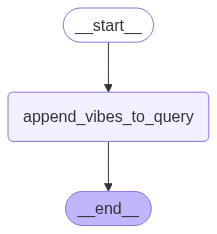

In [9]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
initial_state = {
    "message": "What a wonderful morning!",
    "answer": "To be discarded probably",
    "vibe": "Totally lazy mood :-) ^^ ^^ !!"
}



In [16]:
result = graph.invoke(initial_state)
result

{'message': 'What a wonderful morning!',
 'answer': 'What a wonderful morning! Totally lazy mood :-) ^^ ^^ !!',
 'vibe': 'Totally lazy mood :-) ^^ ^^ !!'}

## Conditional graph

In [30]:
class State(BaseModel):
    message: str
    answer: str = ""

In [48]:
def return_simple_answer(state: State) -> dict:
    return {"answer": "I am here to add some vibes!"}


In [24]:
def router(state: State) -> Literal['append_vibe_1', 'append_vibe_2', 'append_vibe_3']:
    vibes = ['append_vibe_1', 'append_vibe_2', 'append_vibe_3']

    vibe_path = random.choice(vibes)

    return vibe_path

In [51]:
def append_vibe_1(state: State) -> dict:
    vibe = 'Badass baby!'
    return {"answer": f"{state.answer} {state.message}  {vibe}"}

def append_vibe_2(state: State) -> dict:
    vibe = 'Hihi Haha ROTFLOLMAOPIP!'
    return {"answer": f"{state.answer} {state.message} {vibe}"}

def append_vibe_3(state: State) -> dict:
    vibe = 'Bored, depressed, overwhelmed, and so on...'
    return {"answer": f"{state.answer} {state.message} {vibe}"}

In [52]:
workflow = StateGraph(State)

workflow.add_node("return_simple_answer", return_simple_answer)
workflow.add_node("append_vibe_1", append_vibe_1)
workflow.add_node("append_vibe_2", append_vibe_2)
workflow.add_node("append_vibe_3", append_vibe_3)

workflow.add_edge(START, "return_simple_answer")
workflow.add_conditional_edges(
    "return_simple_answer",
    router
)
workflow.add_edge("append_vibe_1", END)
workflow.add_edge("append_vibe_2", END)
workflow.add_edge("append_vibe_3", END)

graph = workflow.compile()



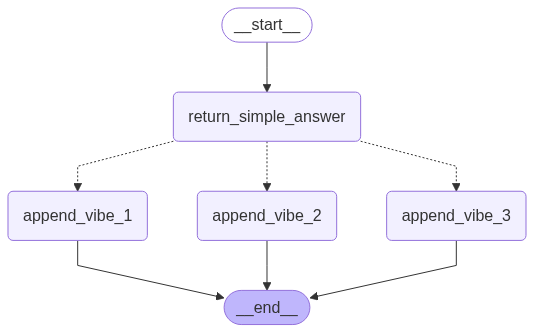

In [28]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [69]:
initial_state = {
    "message": "Gimme some!",
}
result = graph.invoke(initial_state)
print(result)

{'message': 'Gimme some!', 'answer': 'I am here to add some vibes! Gimme some! Hihi Haha ROTFLOLMAOPIP!'}


# Agent graph

In [4]:
def append_vibes(query: str, vibe: str) -> str:
    """
    It takes in a query and a vibe and returns a string with the vibe appended to the query.

    Args:
        query: The query to append the vibe to.
        vibe: The vibe to append to the query.

    Returns:
        str: The query with the vibe appended to it.
    """

    # print(f'Appending vibe: {vibe} to {query}')
    print(f"{query} {vibe}")
    return f'{query} {vibe}'

In [5]:
function_string = inspect.getsource(append_vibes)

In [6]:
print(function_string)

def append_vibes(query: str, vibe: str) -> str:
    """
    It takes in a query and a vibe and returns a string with the vibe appended to the query.

    Args:
        query: The query to append the vibe to.
        vibe: The vibe to append to the query.

    Returns:
        str: The query with the vibe appended to it.
    """

    # print(f'Appending vibe: {vibe} to {query}')
    print(f"{query} {vibe}")
    return f'{query} {vibe}'



In [7]:
result = parse_function_definition(function_string)
result

NameError: name 'parse_function_definition' is not defined

### Back to agent creation after lil' experiments

In [38]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class AgentResponse(BaseModel):
    tool_calls: List[ToolCall] = Field(default_factory=list)
    answer: str

class State(BaseModel):
    messages: Annotated[List[Any], add] = [] # reducer (it will add messages to the list)
    message: str = ""
    iteration: int = Field(default=0)
    answer: str = ""
    available_tools: List[Dict[str, Any]] = [] # returning will override last value
    tool_calls: List[ToolCall] = Field(default_factory=list)


In [68]:
tool_descriptions

[{'name': 'append_vibes',
  'description': 'It takes in a query and a vibe and returns a string with the vibe appended to the query.',
  'parameters': {'type': 'object',
   'properties': {'query': {'type': 'string',
     'description': 'The query to append the vibe to.'},
    'vibe': {'type': 'string',
     'description': 'The vibe to append to the query.'}}},
  'required': ['query', 'vibe'],
  'returns': {'type': 'string',
   'description': 'str: The query with the vibe appended to it.'}}]

In [104]:
def agent_node(state: State) -> dict:
   prompt_template =  """You are a assistant that is generating vibes for a user.

You will be given a selection of tools you can use to add vibes to a user's query.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Instructions:
- You need to use the tools to add vibes to the user's query.
- Add a random vibe to the user's query.
""" 
   print("in agent node")
   template = Template(prompt_template)

   prompt = template.render(
      available_tools=state.available_tools
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
      model="gpt-4.1-mini",
      response_model=AgentResponse,
      messages=[{"role": "system", "content": prompt}, {"role": "user", "content": state.message}],
      temperature=0.5,
   )

   if response.tool_calls:
      tool_calls = []
      for i, tc in enumerate(response.tool_calls):
         tool_calls.append({
               "id": f"call_{i}",
               "name": tc.name,
               "args": tc.arguments
         })

      ai_message = AIMessage(
         content=response.answer,
         tool_calls=tool_calls
      )
   else:
      ai_message = AIMessage(
         content=response.answer,
      )

   return {
      "messages": [ai_message],
      "tool_calls": response.tool_calls
   }


In [65]:
def tool_router(state: State) -> str:
    """Decide whether to continue or end"""

    if len(state.tool_calls) > 0:
        return 'tools'
    else:
        return 'end'


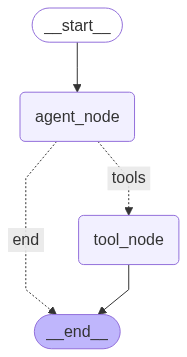

In [ ]:
workflow = StateGraph(State)

tools = [append_vibes]

tool_node = ToolNode(tools)

tool_descriptions = get_tool_descriptions_from_node(tool_node)

workflow.add_node('agent_node', agent_node)
workflow.add_node('tool_node', tool_node)

workflow.add_edge(START, "agent_node")
workflow.add_conditional_edges(
    'agent_node',
    tool_router,
    {
        'tools': 'tool_node',
        'end': END
    }
)
# workflow.add_edge('tool_node', END)x why not in Aurimas lecture?


graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [128]:
initial_state = {
    "message": "Gimme some vibes!",
    'available_tools': tool_descriptions
}
result = graph.invoke(initial_state)

in agent node
Sure! Please provide me with the query you'd like me to add a vibe to. chill and positive


In [108]:
for data in result['messages']:
    print(data)

content='Here you go with some chill and positive vibes added to your request!' additional_kwargs={} response_metadata={} tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Gimme some vibes!', 'vibe': 'chill and positive'}, 'id': 'call_0', 'type': 'tool_call'}]
content='Gimme some vibes! chill and positive' name='append_vibes' tool_call_id='call_0'


## Agent graph with loopback from tools

In [111]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

class AgentResponse(BaseModel):
    tool_calls: List[ToolCall] = Field(default_factory=list)
    answer: str

class State(BaseModel):
    messages: Annotated[List[Any], add] = [] # reducer (it will add messages to the list)
    message: str = ""
    iteration: int = Field(default=0)
    answer: str = ""
    available_tools: List[Dict[str, Any]] = [] # returning will override last value
    tool_calls: List[ToolCall] = Field(default_factory=list)

In [112]:
def append_vibes(query: str, vibe: str) -> str:
    """
    It takes in a query and a vibe and returns a string with the vibe appended to the query.

    Args:
        query: The query to append the vibe to.
        vibe: The vibe to append to the query.

    Returns:
        str: The query with the vibe appended to it.
    """

    # print(f'Appending vibe: {vibe} to {query}')
    print(f"{query} {vibe}")
    return f'{query} {vibe}'

##### Appending messages - short term memory

In [165]:
def agent_node(state: State) -> dict:
   prompt_template =  """You are a assistant that is generating vibes for a user.

You will be given a selection of tools you can use to add vibes to a user's query.

<Available tools>
{{ available_tools | tojson }}
</Available tools>

When you need to use a tool, format your response as:

<tool_call>
{"name": "tool_name", "arguments": {...}}
</tool_call>

Instructions:
- You need to use the tools to add vibes to the user's query.
- Add a random vibe to the user's query.
- Once you have the vibe from the tool, return it as an answer, you can reformulate it a bit and add some l33t speak to it.
""" 
   print("in agent node")
   template = Template(prompt_template)

   prompt = template.render(
      available_tools=state.available_tools
   )

   messages = state.messages

   conversation = []
   for message in messages:
      conversation.append(lc_messages_to_regular_messages(message))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
      model="gpt-4.1-mini",
      response_model=AgentResponse,
      messages=[{"role": "system", "content": prompt}, *conversation],
      temperature=0.5,
   )

   if response.tool_calls:
      tool_calls = []
      for i, tc in enumerate(response.tool_calls):
         tool_calls.append({
               "id": f"call_{i}",
               "name": tc.name,
               "args": tc.arguments
         })

      ai_message = AIMessage(
         content=response.answer,
         tool_calls=tool_calls
      )
   else:
      ai_message = AIMessage(
         content=response.answer,
      )

   return {
      "messages": [ai_message],
      "tool_calls": response.tool_calls,
      "iteration": state.iteration + 1,
      "answer": response.answer,
   }


In [158]:
def tool_router(state: State) -> str:
    """Decide whether to continue or end"""

    if state.iteration > 3:
        return 'end'
    elif len(state.tool_calls) > 0:
        return 'tools'
    else:
        return 'end'

In [166]:
workflow = StateGraph(State)

tools = [append_vibes]

tool_node = ToolNode(tools)

tool_descriptions = get_tool_descriptions_from_node(tool_node)

workflow.add_node('agent_node', agent_node)
workflow.add_node('tool_node', tool_node)

workflow.add_edge(START, "agent_node")
workflow.add_conditional_edges(
    'agent_node',
    tool_router,
    {
        'tools': 'tool_node',
        'end': END
    }
)
workflow.add_edge('tool_node', 'agent_node')

graph = workflow.compile()

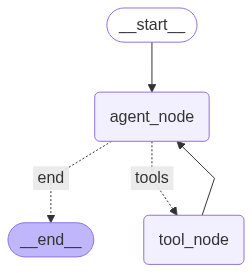

In [133]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [170]:
initial_state = {
    "messages": [{"role": "user", "content": "Gimme some vibes!"}],
    "available_tools": tool_descriptions
}

result = graph.invoke(initial_state)

in agent node
Gimme some vibes! chill and positive
in agent node


In [171]:
result

{'messages': [{'role': 'user', 'content': 'Gimme some vibes!'},
  AIMessage(content='Appending a chill and positive vibe to your query.', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Gimme some vibes!', 'vibe': 'chill and positive'}, 'id': 'call_0', 'type': 'tool_call'}]),
  ToolMessage(content='Gimme some vibes! chill and positive', name='append_vibes', tool_call_id='call_0'),
  AIMessage(content="Here you go, Gimme some vibes! chill and positive — totally chillax mode activated, keepin' it 100! 😎✌️", additional_kwargs={}, response_metadata={})],
 'iteration': 2,
 'answer': "Here you go, Gimme some vibes! chill and positive — totally chillax mode activated, keepin' it 100! 😎✌️",
 'available_tools': [{'name': 'append_vibes',
   'description': 'It takes in a query and a vibe and returns a string with the vibe appended to the query.',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string',
      'descriptio

# Tools copy pasted from Aurimas Github

In [12]:
def parse_function_definition(function_def: str) -> Dict[str, Any]:
    """Parse a function definition string to extract metadata including type hints."""
    result = {
        "name": "",
        "description": "",
        "parameters": {"type": "object", "properties": {}},
        "required": [],
        "returns": {"type": "string", "description": ""}
    }
    
    # Parse the function using AST
    tree = ast.parse(function_def.strip())
    if not tree.body or not isinstance(tree.body[0], ast.FunctionDef):
        return result
        
    func = tree.body[0]
    result["name"] = func.name
    
    # Extract docstring
    docstring = ast.get_docstring(func) or ""
    if docstring:
        # Extract description (first line/paragraph)
        desc_end = docstring.find('\n\n') if '\n\n' in docstring else docstring.find('\nArgs:')
        desc_end = desc_end if desc_end > 0 else docstring.find('\nParameters:')
        result["description"] = docstring[:desc_end].strip() if desc_end > 0 else docstring.strip()
        
        # Parse parameter descriptions
        param_descs = parse_docstring_params(docstring)
        
        # Extract return description
        if "Returns:" in docstring:
            result["returns"]["description"] = docstring.split("Returns:")[1].strip().split('\n')[0]
    
    # Extract parameters with type hints
    args = func.args
    defaults = args.defaults
    num_args = len(args.args)
    num_defaults = len(defaults)
    
    for i, arg in enumerate(args.args):
        if arg.arg == 'self':
            continue
            
        param_info = {
            "type": get_type_from_annotation(arg.annotation) if arg.annotation else "string",
            "description": param_descs.get(arg.arg, "")
        }
        
        # Check for default value
        default_idx = i - (num_args - num_defaults)
        if default_idx >= 0:
            param_info["default"] = ast.literal_eval(ast.unparse(defaults[default_idx]))
        else:
            result["required"].append(arg.arg)
        
        result["parameters"]["properties"][arg.arg] = param_info
    
    # Extract return type
    if func.returns:
        result["returns"]["type"] = get_type_from_annotation(func.returns)
    
    return result


def get_type_from_annotation(annotation) -> str:
    """Convert AST annotation to type string."""
    if not annotation:
        return "string"
    
    type_map = {
        'str': 'string',
        'int': 'integer', 
        'float': 'number',
        'bool': 'boolean',
        'list': 'array',
        'dict': 'object',
        'List': 'array',
        'Dict': 'object'
    }
    
    if isinstance(annotation, ast.Name):
        return type_map.get(annotation.id, annotation.id)
    elif isinstance(annotation, ast.Subscript) and isinstance(annotation.value, ast.Name):
        base_type = annotation.value.id
        return type_map.get(base_type, base_type.lower())
    
    return "string"


def parse_docstring_params(docstring: str) -> Dict[str, str]:
    """Extract parameter descriptions from docstring (handles both Args: and Parameters: formats)."""
    params = {}
    lines = docstring.split('\n')
    in_params = False
    current_param = None
    
    for line in lines:
        stripped = line.strip()
        
        # Check for parameter section start
        if stripped in ['Args:', 'Arguments:', 'Parameters:', 'Params:']:
            in_params = True
            current_param = None
        elif stripped.startswith('Returns:') or stripped.startswith('Raises:'):
            in_params = False
        elif in_params:
            # Parse parameter line (handles "param: desc" and "- param: desc" formats)
            if ':' in stripped and (stripped[0].isalpha() or stripped.startswith(('-', '*'))):
                param_name = stripped.lstrip('- *').split(':')[0].strip()
                param_desc = ':'.join(stripped.lstrip('- *').split(':')[1:]).strip()
                params[param_name] = param_desc
                current_param = param_name
            elif current_param and stripped:
                # Continuation of previous parameter description
                params[current_param] += ' ' + stripped
    
    return params

In [17]:
def get_tool_descriptions_from_node(tool_node):
    """Extract tool descriptions from the ToolNode object."""
    descriptions = []
    
    if hasattr(tool_node, 'tools_by_name'):
        tools_by_name = tool_node.tools_by_name
        
        for tool_name, tool in tools_by_name.items():
            function_string = inspect.getsource(globals()[tool_name])
            # function_string = inspect.getsource(getattr(tool_name))
            result = parse_function_definition(function_string)

            if result:
                descriptions.append(result)
    
    return descriptions if descriptions else "Could not extract tool descriptions"

# TK experiments, mutable v immutable

In [151]:
def append_to_list(value, lst=[]):  # ZŁO
    lst.append(value)
    return lst

print(append_to_list(1))  # [1]
print(append_to_list(2))  # [1, 2]  ← ups!

[1]
[1, 2]


In [152]:
def lc_messages_to_regular_messages(msg):

    if isinstance(msg, dict):
        
        if msg.get("role") == "user":
            return {"role": "user", "content": msg["content"]}
        elif msg.get("role") == "assistant":
            return {"role": "assistant", "content": msg["content"]}
        elif msg.get("role") == "tool":
            return {
                "role": "tool", 
                "content": msg["content"], 
                "tool_call_id": msg.get("tool_call_id")
            }
        
    elif isinstance(msg, AIMessage):

        result = {
            "role": "assistant",
            "content": msg.content
        }
        
        if hasattr(msg, 'tool_calls') and msg.tool_calls and len(msg.tool_calls) > 0 and not msg.tool_calls[0].get("name").startswith("functions."):
            result["tool_calls"] = [
                {
                    "id": tc["id"],
                    "type": "function",
                    "function": {
                        "name": tc["name"].replace("functions.", ""),
                        "arguments": json.dumps(tc["args"])
                    }
                }
                for tc in msg.tool_calls
            ]
            
        return result
    
    elif isinstance(msg, ToolMessage):

        return {"role": "tool", "content": msg.content, "tool_call_id": msg.tool_call_id}
    
    else:

        return {"role": "user", "content": str(msg)}

In [153]:
class BrokenState():
    tool_calls: List[ToolCall] = []  # NIE rób tak!

b1 = BrokenState()
b2 = BrokenState()
b1.tool_calls.append(ToolCall(name="fail", arguments={}))

print(b1.tool_calls)  # TU TEŻ BĘDZIE TOOLCALL!
print(b2.tool_calls)  # TU TEŻ BĘDZIE TOOLCALL!

[ToolCall(name='fail', arguments={})]
[ToolCall(name='fail', arguments={})]


In [154]:
class BrokenState(BaseModel):
    tool_calls: List[ToolCall] = []  # NIE rób tak!

b1 = BrokenState()
b2 = BrokenState()
b1.tool_calls.append(ToolCall(name="fail", arguments={}))

print(b1.tool_calls)  # Pydantic protction
print(b2.tool_calls)  # 

[ToolCall(name='fail', arguments={})]
[]
